In [1]:
import os
from csv import reader

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Neurokit package
import neurokit2 as nk
# RR Interval Processing package
import hrvanalysis as hrvana

In [3]:
# Returns the scores on the N-back tasks
def get_n_back_score(block_dir):
    # return the final score (float from 0.0-1.0) of the N-back task that the user played (0-100)
    n_back_file = None
    for content in os.listdir(block_dir):
        if ".csv" in content:
            n_back_file = content
            break
    if not n_back_file:
        return 0
    
    with open(os.path.join(block_dir, n_back_file), "r") as file:
        csv_reader = reader(file)
        last_row = list(csv_reader)[-1]
        
    # Example row: ['3_Letter_C.png', '', '11', '0', '67', '1', '97.46835443037975', '0.0']
    # Second last column of the last row represents the final score in the game
    return round(float(last_row[-2]) / 100, 2)

In [4]:
def extract_bsp_features(block_dir):
    # Return as Pandas DF containing all relevant BSP (ECG, GSR, Breathing, EMG, PulOxR, PulOxlR)
    bsp_dir = os.path.join(block_dir, "bsp")
    bsp_file_name = os.listdir(bsp_dir)[0]
    bsp_file_path = os.path.join(bsp_dir, bsp_file_name)
    bsp_data = pd.read_csv(bsp_file_path)
    return bsp_data

In [5]:
def get_ecg_features(bsp_data):
    ecg_data = bsp_data['ECG'].values
    signals, info = nk.ecg_process(ecg_data, sampling_rate=1000)
    peaks, p_info = nk.ecg_peaks(ecg_data, sampling_rate=1000)
    nk.ecg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    ecg_features = signals[["ECG_Raw", "ECG_Clean", "ECG_Rate", "ECG_Quality"]]
    
    # Also, compute HRV indices
    hrv_time = nk.hrv_time(peaks, sampling_rate=1000, show=True)
    hrv_freq = nk.hrv_frequency(peaks, sampling_rate=1000, show=True)
    hrv_non = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=True)
    hrv_all = nk.hrv(peaks, sampling_rate=1000, show=True)
    return ecg_features, hrv_time, hrv_freq, hrv_non, hrv_all

In [6]:
cog_data_dir = "/home/ashish/Documents/github/VA/data/cognitive_data"
phy_data_dir = "/home/ashish/Documents/github/VA/data/physical_data"

In [7]:
session_counter = 0
for user_id in range(1, 10):
    user_dir = os.path.join(cog_data_dir, f"user_{user_id}")
    for session in os.listdir(user_dir):
        session_dir = os.path.join(user_dir, session)
        for block in os.listdir(session_dir):
            # Sanity check if the directory has the name "block" or not
            if "block" not in block or "practice" in block.lower():
                # Ignore directories other than block
                continue
            block_dir = os.path.join(session_dir, block)
            # For each block, we want to extract three different sets of data
            score = get_n_back_score(block_dir)
            print(f"{session_counter+1}. Score: {score} | Session: {session[-1]} | User_ID: {user_id}")
            session_counter += 1
            bsp_data = extract_bsp_features(block_dir)
            break
        break
    break

1. Score: 0.97 | Session: 1 | User_ID: 1


In [8]:
bsp_data

,Time,ECG,GSR,Breathing,EMG,PulOxR,PulOxIR
0,14:59:58.854092,27162.0,11219.0,59604.0,32789.0,0.0,0.0
1,14:59:58.854137,27176.0,11222.0,59613.0,32757.0,0.0,0.0
2,14:59:58.854155,27188.0,11229.0,59615.0,32722.0,28732.0,10314.0
3,14:59:58.854171,27228.0,11228.0,59751.0,32912.0,28732.0,10314.0
4,14:59:58.856554,27292.0,11258.0,59751.0,32743.0,29550.0,10093.0
...,...,...,...,...,...,...,...
172516,15:02:51.484125,36478.0,9413.0,27303.0,32790.0,29542.0,11293.0
172517,15:02:51.485730,36472.0,9444.0,27269.0,32788.0,29544.0,11289.0
172518,15:02:51.486155,36464.0,9422.0,27271.0,32708.0,29544.0,11289.0
172519,15:02:51.486238,36473.0,9471.0,27357.0,32796.0,29543.0,11287.0


## Cleaning ECG and Detecting R-points

- Use Pan and Tompkins proposed QRS detection algorithm for cleaning ECG data

In [9]:
cleaned = nk.ecg_clean(bsp_data['ECG'], sampling_rate=1000, method="pantompkins1985")
pantompkins1985 = nk.ecg_findpeaks(cleaned, method="pantompkins1985") # find the R peaks

In [11]:
cleaned

array([-171.14260997, -502.08093177, -810.61908831, ..., 4040.89621501,
       3947.99189049, 3850.3286824 ])

- The **ECG_R_Peaks** column contains the time difference in seconds from each R peak to the start of the recording. We will calculate the RR intervals based on the difference between each R point in the following cells.

In [16]:
# Converting peaks values into a DF
hrv_df = pd.DataFrame(pantompkins1985)
hrv_df.head()

,ECG_R_Peaks
0,346
1,1069
2,1709
3,2338
4,2960


In [17]:
# RR_intervals are basically the difference between two adjacent points
hrv_df['RR_Intervals'] = hrv_df['ECG_R_Peaks'].diff()
# Fix the first value to 0, as it will be NaN
hrv_df.loc[0, 'RR_Intervals'] = hrv_df.loc[0]['ECG_R_Peaks']
hrv_df.head()

,ECG_R_Peaks,RR_Intervals
0,346,346.0
1,1069,723.0
2,1709,640.0
3,2338,629.0
4,2960,622.0


## RR Interval Visualization

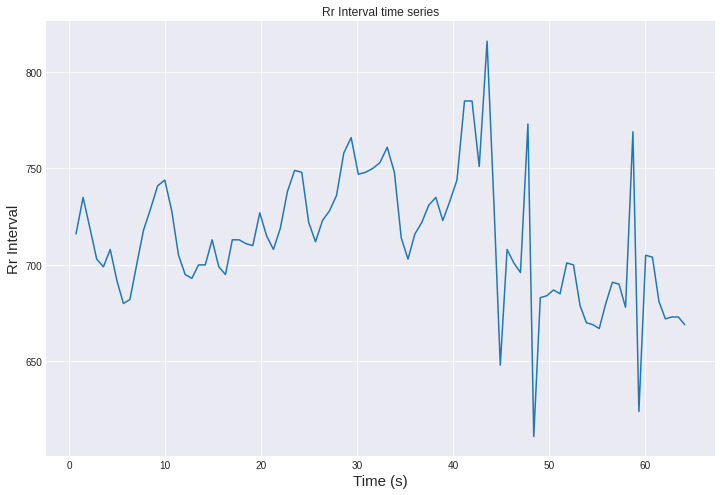

Text(0.5, 0, 'RR_Interval Index')

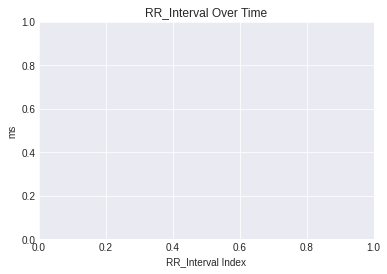

In [21]:
hrvana.plot_timeseries(hrv_df["RR_Intervals"].values.tolist()[10:100]) # visualise 90 RR intervals
plt.title("RR_Interval Over Time")
plt.ylabel("ms")
plt.xlabel("RR_Interval Index")

## RR Interval Data Cleaning

### To clean HRV data:
- Remove outliers: Accept a valid RR interval between 300 ms to 2000 ms
- Interpolate **removed NaN** values with forward linear interpolation (values calculated using future RR intervals). We ignore the index and treat the values as equally spaced.
    - Ref: [Pandas Interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) [HRV-Analysis Interpolation](https://github.com/Aura-healthcare/hrv-analysis/blob/master/hrvanalysis/preprocessing.py)
    
- Use method proposed by [Malik M et al.](https://onlinelibrary.wiley.com/doi/10.1111/j.1542-474X.1996.tb00275.x) **Heart Rate Variability** to remove ectopic bias
- Interpolate removed NaN with forward linear interpolation

In [22]:
clean_rri = hrv_df['RR_Intervals'].values
clean_rri = hrvana.remove_outliers(rr_intervals=clean_rri, low_rri=300, high_rri=2000)
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")
clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")

0 outlier(s) have been deleted.
6 ectopic beat(s) have been deleted with malik rule.


#### The NN intervals are the processed RR intervals. Let's visualize the NN intervals

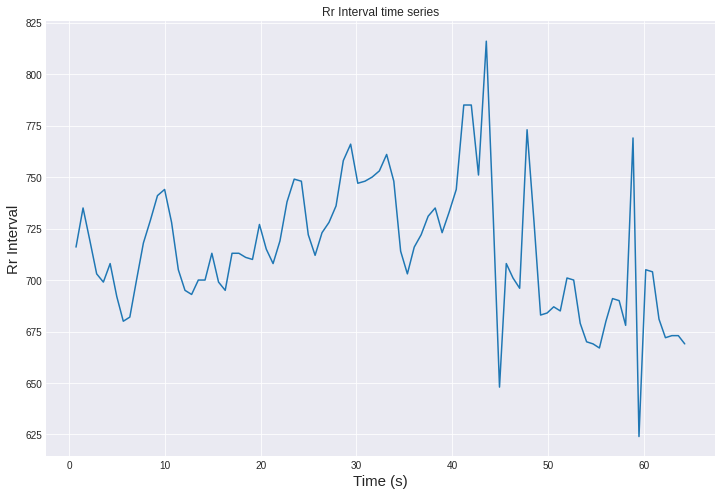

Text(0.5, 0, 'NN Interval Index')

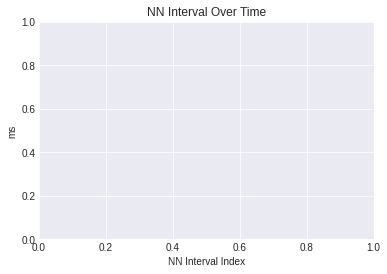

In [23]:
hrvana.plot_timeseries(clean_rri[10:100]) # due to the size of the dataset, here we only show the 90 nnis
plt.title("NN intervals")
plt.title("NN Interval Over Time")
plt.ylabel("ms")
plt.xlabel("NN Interval Index")

In [26]:
pd.DataFrame(clean_rri).head()

,0
0,346.0
1,493.0
2,640.0
3,629.0
4,622.0


In [27]:
hrv_df['RR_Intervals'] = clean_rri
hrv_df['RR_Intervals'].isna().any()

False

In [28]:
hrv_df.head()

,ECG_R_Peaks,RR_Intervals
0,346,346.0
1,1069,493.0
2,1709,640.0
3,2338,629.0
4,2960,622.0


## HRV Feature Extraction